In [1]:
import tensorflow as tf
import time
from datetime import timedelta
import numpy as np
ks=tf.keras

2022-12-15 16:34:11.425277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 16:34:11.518035: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-15 16:34:11.520501: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-15 16:34:11.520511: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## 1. Data

In [2]:
from kgcnn.graph.base import GraphDict
from kgcnn.data.base import MemoryGraphList, MemoryGraphDataset
from kgcnn.data.qm import QMDataset

In [3]:
dataset = QMDataset(data_directory="ExampleQM", file_name="thiol.csv", dataset_name="ThiolDisulfidExchange")

In [4]:
dataset.prepare_data(overwrite=True, make_sdf = True);

INFO:kgcnn.data.ThiolDisulfidExchange:Converting xyz to mol information.


In [5]:
dataset.read_in_memory(label_column_name="energies");

INFO:kgcnn.data.ThiolDisulfidExchange:Reading structures from SDF file.
INFO:kgcnn.data.ThiolDisulfidExchange: ... process molecules 0 from 5112
INFO:kgcnn.data.ThiolDisulfidExchange: ... process molecules 5000 from 5112


In [6]:
dataset.map_list(method="set_range", max_distance=5.0);
dataset.map_list(method="set_angle");

In [7]:
dataset.save();

INFO:kgcnn.data.ThiolDisulfidExchange:Pickle dataset...


In [8]:
dataset2 = MemoryGraphDataset(data_directory="ExampleQM", dataset_name="ThiolDisulfidExchange")
dataset2.load();
dataset2[0].keys()

INFO:kgcnn.data.ThiolDisulfidExchange:Load pickled dataset...


dict_keys(['node_symbol', 'node_number', 'node_coordinates', 'edge_indices', 'edge_number', 'graph_labels', 'range_indices', 'range_attributes', 'angle_indices', 'angle_indices_nodes', 'angle_attributes'])

## 2. Model

In [9]:
from kgcnn.literature.HDNNP2nd import make_model

In [10]:
model_config = {
    "name": "HDNNP2nd",
    "inputs": [{"shape": (None,), "name": "node_number", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "node_coordinates", "dtype": "float32", "ragged": True},
               {"shape": (None, 2), "name": "edge_indices", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "angle_indices_nodes", "dtype": "int64", "ragged": True}],
    "w_acsf_ang_kwargs": {},
    "w_acsf_rad_kwargs": {},
    "mlp_kwargs": {"units": [64, 64, 1],
                   "num_relations": 96,
                   "activation": ["swish", "swish", "linear"]},
    "node_pooling_args": {"pooling_method": "sum"},
    "verbose": 10,
    "output_embedding": "graph", "output_to_tensor": True,
    "use_output_mlp": False,
    "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                   "activation": ["swish", "linear"]}
}

In [11]:
model = make_model(**model_config)

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'HDNNP2nd', 'inputs': [{'shape': (None,), 'name': 'node_number', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'node_coordinates', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'angle_indices_nodes', 'dtype': 'int64', 'ragged': True}], 'w_acsf_ang_kwargs': {}, 'w_acsf_rad_kwargs': {}, 'mlp_kwargs': {'units': [64, 64, 1], 'num_relations': 96, 'activation': ['swish', 'swish', 'linear']}, 'node_pooling_args': {'pooling_method': 'sum'}, 'verbose': 10, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_output_mlp': False, 'output_mlp': {'use_bias': [True, True], 'units': [64, 1], 'activation': ['swish', 'linear']}}
2022-12-15 16:34:37.370756: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: can

In [12]:
inputs = dataset.tensor(model_config["inputs"])

In [13]:
model.predict(inputs).shape

160/160 [==============================] - 4s 21ms/step


(5112, 1)

In [14]:
from kgcnn.scaler.mol import ExtensiveMolecularScaler
scaler = ExtensiveMolecularScaler(standardize_scale=False)
labels = np.expand_dims(np.array(dataset.get("graph_labels"))/0.0367493, axis=-1)

In [15]:
labels = scaler.fit_transform(labels, atomic_number=dataset.get("node_number"))
labels.shape

(5112, 1)

In [16]:
from sklearn.model_selection import KFold
kf = KFold(n_splits= 5, random_state=42, shuffle=True)

In [21]:
for train_index, test_index in kf.split(X=labels):
    model = make_model(**model_config)
    model.compile(loss="mean_absolute_error", metrics=["mean_absolute_error"], 
                  optimizer=ks.optimizers.Adam(learning_rate=1e-3))
    
    x_train, y_train = dataset[train_index].tensor(model_config["inputs"]), labels[train_index]
    x_test, y_test = dataset[test_index].tensor(model_config["inputs"]), labels[test_index]
    
    start = time.process_time()
    hist = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=100,
    )
    stop = time.process_time()
    print("Print Time for training: ", str(timedelta(seconds=stop - start)))
    print(model.summary())

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'HDNNP2nd', 'inputs': [{'shape': (None,), 'name': 'node_number', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'node_coordinates', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'angle_indices_nodes', 'dtype': 'int64', 'ragged': True}], 'w_acsf_ang_kwargs': {}, 'w_acsf_rad_kwargs': {}, 'mlp_kwargs': {'units': [64, 64, 1], 'num_relations': 96, 'activation': ['swish', 'swish', 'linear']}, 'node_pooling_args': {'pooling_method': 'sum'}, 'verbose': 10, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_output_mlp': False, 'output_mlp': {'use_bias': [True, True], 'units': [64, 1], 'activation': ['swish', 'linear']}}
/home/patrickreiser/anaconda3/envs/gcnn_keras_test/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded a

Epoch 1/100
128/128 [==============================] - 5s 31ms/step - loss: 15.7382 - mean_absolute_error: 15.7382 - val_loss: 12.3709 - val_mean_absolute_error: 12.3709
Epoch 2/100
128/128 [==============================] - 4s 28ms/step - loss: 10.2157 - mean_absolute_error: 10.2157 - val_loss: 10.1724 - val_mean_absolute_error: 10.1724
Epoch 3/100
128/128 [==============================] - 4s 27ms/step - loss: 16.8059 - mean_absolute_error: 16.8059 - val_loss: 9.0816 - val_mean_absolute_error: 9.0816
Epoch 4/100
128/128 [==============================] - 4s 28ms/step - loss: 13.8794 - mean_absolute_error: 13.8794 - val_loss: 12.3084 - val_mean_absolute_error: 12.3084
Epoch 5/100
128/128 [==============================] - 4s 28ms/step - loss: 24.4295 - mean_absolute_error: 24.4295 - val_loss: 30.6512 - val_mean_absolute_error: 30.6512
Epoch 6/100
128/128 [==============================] - 4s 28ms/step - loss: 13.5346 - mean_absolute_error: 13.5346 - val_loss: 23.9854 - val_mean_absolu

Epoch 50/100
128/128 [==============================] - 4s 28ms/step - loss: 3.5160 - mean_absolute_error: 3.5160 - val_loss: 3.6849 - val_mean_absolute_error: 3.6849
Epoch 51/100
128/128 [==============================] - 4s 28ms/step - loss: 2.8634 - mean_absolute_error: 2.8634 - val_loss: 3.0803 - val_mean_absolute_error: 3.0803
Epoch 52/100
128/128 [==============================] - 4s 28ms/step - loss: 3.0567 - mean_absolute_error: 3.0567 - val_loss: 1.0585 - val_mean_absolute_error: 1.0585
Epoch 53/100
128/128 [==============================] - 4s 28ms/step - loss: 2.8535 - mean_absolute_error: 2.8535 - val_loss: 4.3914 - val_mean_absolute_error: 4.3914
Epoch 54/100
128/128 [==============================] - 4s 28ms/step - loss: 3.4017 - mean_absolute_error: 3.4017 - val_loss: 0.8608 - val_mean_absolute_error: 0.8608
Epoch 55/100
128/128 [==============================] - 4s 28ms/step - loss: 2.9978 - mean_absolute_error: 2.9978 - val_loss: 0.7678 - val_mean_absolute_error: 0.767

128/128 [==============================] - 4s 30ms/step - loss: 1.1396 - mean_absolute_error: 1.1396 - val_loss: 0.9742 - val_mean_absolute_error: 0.9742
Epoch 100/100
128/128 [==============================] - 4s 32ms/step - loss: 1.0759 - mean_absolute_error: 1.0759 - val_loss: 0.7205 - val_mean_absolute_error: 0.7205
Print Time for training:  0:23:13.087841
Model: "HDNNP2nd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_number (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 node_coordinates (InputLayer)  [(None, None, 3)]    0           []                               
                                                                                                  
 edge_indices (InputLayer

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'HDNNP2nd', 'inputs': [{'shape': (None,), 'name': 'node_number', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'node_coordinates', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'angle_indices_nodes', 'dtype': 'int64', 'ragged': True}], 'w_acsf_ang_kwargs': {}, 'w_acsf_rad_kwargs': {}, 'mlp_kwargs': {'units': [64, 64, 1], 'num_relations': 96, 'activation': ['swish', 'swish', 'linear']}, 'node_pooling_args': {'pooling_method': 'sum'}, 'verbose': 10, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_output_mlp': False, 'output_mlp': {'use_bias': [True, True], 'units': [64, 1], 'activation': ['swish', 'linear']}}


None
Epoch 1/100
128/128 [==============================] - 5s 31ms/step - loss: 17.3590 - mean_absolute_error: 17.3590 - val_loss: 3.7794 - val_mean_absolute_error: 3.7794
Epoch 2/100
128/128 [==============================] - 4s 28ms/step - loss: 16.9322 - mean_absolute_error: 16.9322 - val_loss: 9.6560 - val_mean_absolute_error: 9.6560
Epoch 3/100
128/128 [==============================] - 4s 27ms/step - loss: 12.8804 - mean_absolute_error: 12.8804 - val_loss: 11.8889 - val_mean_absolute_error: 11.8889
Epoch 4/100
128/128 [==============================] - 4s 28ms/step - loss: 10.5388 - mean_absolute_error: 10.5388 - val_loss: 11.1773 - val_mean_absolute_error: 11.1773
Epoch 5/100
128/128 [==============================] - 4s 29ms/step - loss: 9.9833 - mean_absolute_error: 9.9833 - val_loss: 14.6348 - val_mean_absolute_error: 14.6348
Epoch 6/100
128/128 [==============================] - 4s 29ms/step - loss: 12.2367 - mean_absolute_error: 12.2367 - val_loss: 17.3065 - val_mean_absol

Epoch 50/100
128/128 [==============================] - 4s 28ms/step - loss: 4.6238 - mean_absolute_error: 4.6238 - val_loss: 1.5115 - val_mean_absolute_error: 1.5115
Epoch 51/100
128/128 [==============================] - 4s 28ms/step - loss: 2.8516 - mean_absolute_error: 2.8516 - val_loss: 4.6963 - val_mean_absolute_error: 4.6963
Epoch 52/100
128/128 [==============================] - 4s 28ms/step - loss: 3.2009 - mean_absolute_error: 3.2009 - val_loss: 2.8864 - val_mean_absolute_error: 2.8864
Epoch 53/100
128/128 [==============================] - 4s 28ms/step - loss: 3.4292 - mean_absolute_error: 3.4292 - val_loss: 2.3125 - val_mean_absolute_error: 2.3125
Epoch 54/100
128/128 [==============================] - 4s 28ms/step - loss: 2.3367 - mean_absolute_error: 2.3367 - val_loss: 2.7762 - val_mean_absolute_error: 2.7762
Epoch 55/100
128/128 [==============================] - 4s 28ms/step - loss: 2.1069 - mean_absolute_error: 2.1069 - val_loss: 0.9227 - val_mean_absolute_error: 0.922

128/128 [==============================] - 4s 28ms/step - loss: 1.8129 - mean_absolute_error: 1.8129 - val_loss: 2.7243 - val_mean_absolute_error: 2.7243
Epoch 100/100
128/128 [==============================] - 4s 28ms/step - loss: 1.2865 - mean_absolute_error: 1.2865 - val_loss: 0.8237 - val_mean_absolute_error: 0.8237
Print Time for training:  0:23:15.195468
Model: "HDNNP2nd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_number (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 node_coordinates (InputLayer)  [(None, None, 3)]    0           []                               
                                                                                                  
 edge_indices (InputLayer

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'HDNNP2nd', 'inputs': [{'shape': (None,), 'name': 'node_number', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'node_coordinates', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'angle_indices_nodes', 'dtype': 'int64', 'ragged': True}], 'w_acsf_ang_kwargs': {}, 'w_acsf_rad_kwargs': {}, 'mlp_kwargs': {'units': [64, 64, 1], 'num_relations': 96, 'activation': ['swish', 'swish', 'linear']}, 'node_pooling_args': {'pooling_method': 'sum'}, 'verbose': 10, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_output_mlp': False, 'output_mlp': {'use_bias': [True, True], 'units': [64, 1], 'activation': ['swish', 'linear']}}


None
Epoch 1/100
128/128 [==============================] - 5s 31ms/step - loss: 78.1941 - mean_absolute_error: 78.1941 - val_loss: 6.2669 - val_mean_absolute_error: 6.2669
Epoch 2/100
128/128 [==============================] - 4s 28ms/step - loss: 15.2336 - mean_absolute_error: 15.2336 - val_loss: 22.7483 - val_mean_absolute_error: 22.7483
Epoch 3/100
128/128 [==============================] - 4s 28ms/step - loss: 16.1687 - mean_absolute_error: 16.1687 - val_loss: 42.9753 - val_mean_absolute_error: 42.9753
Epoch 4/100
128/128 [==============================] - 4s 28ms/step - loss: 21.9142 - mean_absolute_error: 21.9142 - val_loss: 21.9288 - val_mean_absolute_error: 21.9288
Epoch 5/100
128/128 [==============================] - 4s 28ms/step - loss: 20.3460 - mean_absolute_error: 20.3460 - val_loss: 24.8277 - val_mean_absolute_error: 24.8277
Epoch 6/100
128/128 [==============================] - 4s 28ms/step - loss: 18.0888 - mean_absolute_error: 18.0888 - val_loss: 17.7277 - val_mean_a

Epoch 50/100
128/128 [==============================] - 4s 28ms/step - loss: 3.9811 - mean_absolute_error: 3.9811 - val_loss: 1.9109 - val_mean_absolute_error: 1.9109
Epoch 51/100
128/128 [==============================] - 4s 28ms/step - loss: 2.0003 - mean_absolute_error: 2.0003 - val_loss: 3.5446 - val_mean_absolute_error: 3.5446
Epoch 52/100
128/128 [==============================] - 4s 28ms/step - loss: 2.8921 - mean_absolute_error: 2.8921 - val_loss: 6.0832 - val_mean_absolute_error: 6.0832
Epoch 53/100
128/128 [==============================] - 4s 28ms/step - loss: 3.3440 - mean_absolute_error: 3.3440 - val_loss: 1.9613 - val_mean_absolute_error: 1.9613
Epoch 54/100
128/128 [==============================] - 4s 28ms/step - loss: 1.8076 - mean_absolute_error: 1.8076 - val_loss: 1.0404 - val_mean_absolute_error: 1.0404
Epoch 55/100
128/128 [==============================] - 4s 28ms/step - loss: 1.8323 - mean_absolute_error: 1.8323 - val_loss: 2.6173 - val_mean_absolute_error: 2.617

128/128 [==============================] - 4s 28ms/step - loss: 1.4337 - mean_absolute_error: 1.4337 - val_loss: 1.7120 - val_mean_absolute_error: 1.7120
Epoch 100/100
128/128 [==============================] - 4s 28ms/step - loss: 1.0246 - mean_absolute_error: 1.0246 - val_loss: 0.8804 - val_mean_absolute_error: 0.8804
Print Time for training:  0:23:14.417504
Model: "HDNNP2nd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_number (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 node_coordinates (InputLayer)  [(None, None, 3)]    0           []                               
                                                                                                  
 edge_indices (InputLayer

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'HDNNP2nd', 'inputs': [{'shape': (None,), 'name': 'node_number', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'node_coordinates', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'angle_indices_nodes', 'dtype': 'int64', 'ragged': True}], 'w_acsf_ang_kwargs': {}, 'w_acsf_rad_kwargs': {}, 'mlp_kwargs': {'units': [64, 64, 1], 'num_relations': 96, 'activation': ['swish', 'swish', 'linear']}, 'node_pooling_args': {'pooling_method': 'sum'}, 'verbose': 10, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_output_mlp': False, 'output_mlp': {'use_bias': [True, True], 'units': [64, 1], 'activation': ['swish', 'linear']}}


None
Epoch 1/100
128/128 [==============================] - 5s 32ms/step - loss: 43.5355 - mean_absolute_error: 43.5355 - val_loss: 16.1576 - val_mean_absolute_error: 16.1576
Epoch 2/100
128/128 [==============================] - 4s 28ms/step - loss: 12.1078 - mean_absolute_error: 12.1078 - val_loss: 9.1186 - val_mean_absolute_error: 9.1186
Epoch 3/100
128/128 [==============================] - 4s 28ms/step - loss: 16.4095 - mean_absolute_error: 16.4095 - val_loss: 8.2546 - val_mean_absolute_error: 8.2546
Epoch 4/100
128/128 [==============================] - 4s 28ms/step - loss: 13.0714 - mean_absolute_error: 13.0714 - val_loss: 8.4714 - val_mean_absolute_error: 8.4714
Epoch 5/100
128/128 [==============================] - 4s 28ms/step - loss: 13.3682 - mean_absolute_error: 13.3682 - val_loss: 7.8679 - val_mean_absolute_error: 7.8679
Epoch 6/100
128/128 [==============================] - 4s 28ms/step - loss: 9.9683 - mean_absolute_error: 9.9683 - val_loss: 15.6091 - val_mean_absolute_

Epoch 50/100
128/128 [==============================] - 4s 28ms/step - loss: 3.6262 - mean_absolute_error: 3.6262 - val_loss: 4.5678 - val_mean_absolute_error: 4.5678
Epoch 51/100
128/128 [==============================] - 4s 28ms/step - loss: 2.9911 - mean_absolute_error: 2.9911 - val_loss: 1.1053 - val_mean_absolute_error: 1.1053
Epoch 52/100
128/128 [==============================] - 4s 29ms/step - loss: 1.5695 - mean_absolute_error: 1.5695 - val_loss: 2.2866 - val_mean_absolute_error: 2.2866
Epoch 53/100
128/128 [==============================] - 4s 28ms/step - loss: 3.5545 - mean_absolute_error: 3.5545 - val_loss: 4.2685 - val_mean_absolute_error: 4.2685
Epoch 54/100
128/128 [==============================] - 4s 28ms/step - loss: 3.6494 - mean_absolute_error: 3.6494 - val_loss: 1.0440 - val_mean_absolute_error: 1.0440
Epoch 55/100
128/128 [==============================] - 4s 28ms/step - loss: 2.1287 - mean_absolute_error: 2.1287 - val_loss: 2.1988 - val_mean_absolute_error: 2.198

128/128 [==============================] - 4s 28ms/step - loss: 1.0896 - mean_absolute_error: 1.0896 - val_loss: 1.3039 - val_mean_absolute_error: 1.3039
Epoch 100/100
128/128 [==============================] - 4s 29ms/step - loss: 1.4674 - mean_absolute_error: 1.4674 - val_loss: 1.5054 - val_mean_absolute_error: 1.5054
Print Time for training:  0:23:18.501169
Model: "HDNNP2nd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_number (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 node_coordinates (InputLayer)  [(None, None, 3)]    0           []                               
                                                                                                  
 edge_indices (InputLayer

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'HDNNP2nd', 'inputs': [{'shape': (None,), 'name': 'node_number', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'node_coordinates', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'angle_indices_nodes', 'dtype': 'int64', 'ragged': True}], 'w_acsf_ang_kwargs': {}, 'w_acsf_rad_kwargs': {}, 'mlp_kwargs': {'units': [64, 64, 1], 'num_relations': 96, 'activation': ['swish', 'swish', 'linear']}, 'node_pooling_args': {'pooling_method': 'sum'}, 'verbose': 10, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_output_mlp': False, 'output_mlp': {'use_bias': [True, True], 'units': [64, 1], 'activation': ['swish', 'linear']}}


None
Epoch 1/100
128/128 [==============================] - 5s 31ms/step - loss: 28.9223 - mean_absolute_error: 28.9223 - val_loss: 7.8223 - val_mean_absolute_error: 7.8223
Epoch 2/100
128/128 [==============================] - 4s 28ms/step - loss: 16.6575 - mean_absolute_error: 16.6575 - val_loss: 39.3084 - val_mean_absolute_error: 39.3084
Epoch 3/100
128/128 [==============================] - 4s 28ms/step - loss: 32.7974 - mean_absolute_error: 32.7974 - val_loss: 15.4441 - val_mean_absolute_error: 15.4441
Epoch 4/100
128/128 [==============================] - 4s 28ms/step - loss: 19.5245 - mean_absolute_error: 19.5245 - val_loss: 49.2516 - val_mean_absolute_error: 49.2516
Epoch 5/100
128/128 [==============================] - 4s 28ms/step - loss: 14.4348 - mean_absolute_error: 14.4348 - val_loss: 6.0874 - val_mean_absolute_error: 6.0874
Epoch 6/100
128/128 [==============================] - 4s 28ms/step - loss: 16.3422 - mean_absolute_error: 16.3422 - val_loss: 18.8136 - val_mean_abs

128/128 [==============================] - 4s 28ms/step - loss: 2.2792 - mean_absolute_error: 2.2792 - val_loss: 2.0270 - val_mean_absolute_error: 2.0270
Epoch 99/100
128/128 [==============================] - 4s 28ms/step - loss: 2.0319 - mean_absolute_error: 2.0319 - val_loss: 0.7830 - val_mean_absolute_error: 0.7830
Epoch 100/100
128/128 [==============================] - 4s 28ms/step - loss: 2.0631 - mean_absolute_error: 2.0631 - val_loss: 1.0545 - val_mean_absolute_error: 1.0545
Print Time for training:  0:23:12.423199
Model: "HDNNP2nd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_number (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 node_coordinates (InputLayer)  [(None, None, 3)]    0  

In [22]:
true_y = scaler.inverse_transform(labels[test_index], atomic_number=dataset[test_index].get("node_number"))
predicted_y = scaler.inverse_transform(model.predict(x_test), atomic_number=dataset[test_index].get("node_number"))

32/32 [==============================] - 1s 22ms/step


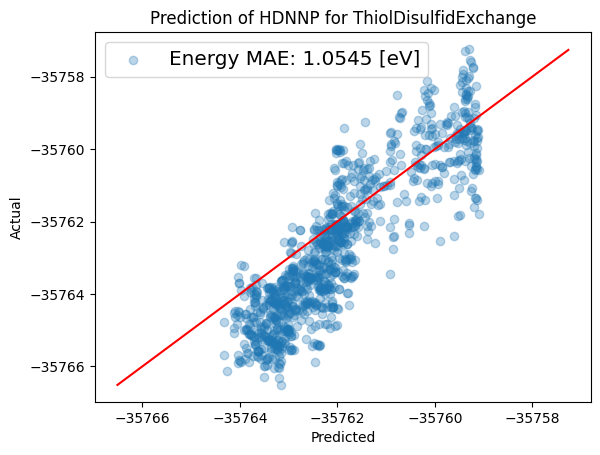

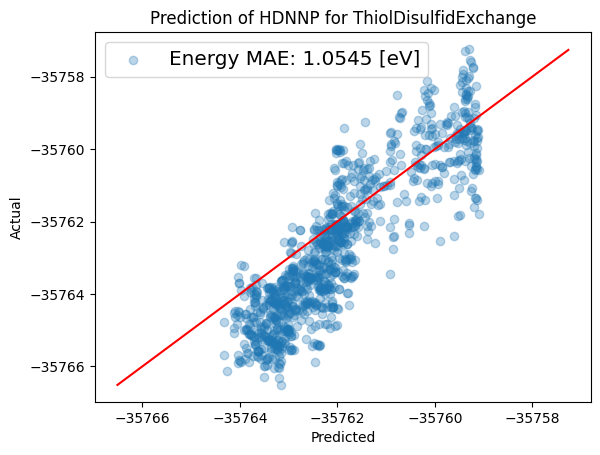

In [23]:
from kgcnn.utils.plots import plot_predict_true
plot_predict_true(predicted_y, true_y,
                  filepath="ExampleQM/", data_unit="eV",
                  model_name="HDNNP", dataset_name="ThiolDisulfidExchange", target_names="Energy",
                  file_name=f"predict.png")

In [24]:
predicted_y.shape

(1022, 1)